In [14]:

import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/JP_Morgan/BTC-USD.csv')

In [15]:
df[2700:2900]

,Date,Open,High,Low,Close,Adj Close,Volume
2700,2022-02-07,42406.781250,44401.863281,41748.156250,43840.285156,43840.285156,28641855926
2701,2022-02-08,43854.652344,45293.867188,42807.835938,44118.445313,44118.445313,33079398868
2702,2022-02-09,44096.703125,44727.800781,43232.968750,44338.796875,44338.796875,23245887300
2703,2022-02-10,44347.800781,45661.171875,43402.808594,43565.113281,43565.113281,32142048537
2704,2022-02-11,43571.128906,43810.832031,42114.539063,42407.937500,42407.937500,26954925781
...,...,...,...,...,...,...,...
2895,2022-08-21,21160.392578,21668.845703,21103.197266,21534.121094,21534.121094,23102307723
2896,2022-08-22,21531.462891,21531.462891,20939.183594,21398.908203,21398.908203,31666498758
2897,2022-08-23,21401.044922,21646.203125,20955.138672,21528.087891,21528.087891,31878280659
2898,2022-08-24,21526.455078,21783.076172,21195.005859,21395.019531,21395.019531,31962253368


In [16]:
df = df[['Date','Close']]
df

,Date,Close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014
...,...,...
3121,2023-04-04,28168.089844
3122,2023-04-05,28177.984375
3123,2023-04-06,28044.140625
3124,2023-04-07,27925.859375


In [17]:
# df['Date']
print(df.columns.tolist())

['Date', 'Close']


In [18]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [19]:
df['Date'] = df['Date'].apply(str_to_datetime)

In [20]:
df.index = df.pop('Date')
df

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2023-04-04,28168.089844
2023-04-05,28177.984375
2023-04-06,28044.140625


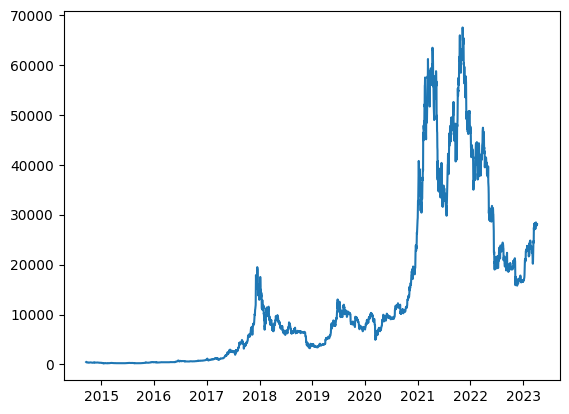

In [21]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [22]:
def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE)  
    """
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))                   
    return rmse

In [23]:
### The effectiveness of prediction method is measured in terms of the Mean Absolute Percentage Error (MAPE) and RMSE
def calculate_mape(y_true, y_pred): 
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)    
    mape = np.mean(np.abs((y_true-y_pred) / y_true))*100    
    return mape

In [26]:
def extract_seqX_outcomeY(data, N, offset):
    """
    Split time-series into training sequence X and outcome value Y
    Args:
        data - dataset 
        N - window size, e.g., 60 for 60 days 
        offset - position to start the split
    """
    X, y = [], []
    
    for i in range(offset, len(data)):
        X.append(data[i-N:i])
        y.append(data[i])
    
    return np.array(X), np.array(y)

In [27]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2022-07-08', 
                                '2023-04-08	', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2022-07-08,20190.115234,20548.246094,21637.587891,21731.117188
1,2022-07-09,20548.246094,21637.587891,21731.117188,21592.207031
2,2022-07-10,21637.587891,21731.117188,21592.207031,20860.449219
3,2022-07-11,21731.117188,21592.207031,20860.449219,19970.556641
4,2022-07-12,21592.207031,20860.449219,19970.556641,19323.914063
...,...,...,...,...,...
270,2023-04-04,28411.035156,28199.308594,27790.220703,28168.089844
271,2023-04-05,28199.308594,27790.220703,28168.089844,28177.984375
272,2023-04-06,27790.220703,28168.089844,28177.984375,28044.140625
273,2023-04-07,28168.089844,28177.984375,28044.140625,27925.859375


In [28]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((275,), (275, 3, 1), (275,))

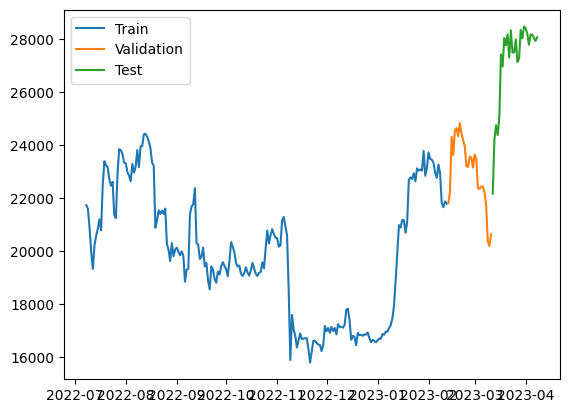

In [29]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [30]:
! pip install tensorflow
!sudo pip3 install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
from datetime import date
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential, Model
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

import tensorflow as tf 
tf.random.set_seed(42)

import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json

In [ ]:
layer_units, optimizer = 50, 'adam' 
cur_epochs = 15
cur_batch_size = 20
    
cur_LSTM_pars = {'units': layer_units, 
                  'optimizer': optimizer, 
                  'batch_size': cur_batch_size, 
                  'epochs': cur_epochs
                  }

# npt_exp = project.create_experiment(name='LSTM', 
#                                     params=cur_LSTM_pars, 
#                                     description='stock-prediction-machine-learning', 
#                                     tags=['stockprediction', 'LSTM','neptune'])
    
## use the past N stock prices for training to predict the N+1th closing price

# scale 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['Close']])
scaled_data_train = scaled_data[:X_train.shape[0]]

X_train, y_train = extract_seqX_outcomeY(scaled_data_train, 50, window_size)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(32),
                    layers.Dense(16, activation='relu'),
                    layers.Dense(16, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 4s 87ms/step - loss: 401881344.0000 - mean_absolute_error: 19900.5234 - val_loss: 531165120.0000 - val_mean_absolute_error: 23011.4238
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 401872480.0000 - mean_absolute_error: 19900.3008 - val_loss: 531154336.0000 - val_mean_absolute_error: 23011.1895
Epoch 3/100
7/7 [==============================] - 0s 12ms/step - loss: 401863136.0000 - mean_absolute_error: 19900.0645 - val_loss: 531143328.0000 - val_mean_absolute_error: 23010.9512
Epoch 4/100
7/7 [==============================] - 0s 9ms/step - loss: 401853280.0000 - mean_absolute_error: 19899.8164 - val_loss: 531131360.0000 - val_mean_absolute_error: 23010.6895
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - loss: 401842432.0000 - mean_absolute_error: 19899.5449 - val_loss: 531118080.0000 - val_mean_absolute_error: 23010.4023
Epoch 6/100
7/7 [==============================] - 0s 12ms/step - loss: 

7/7 [==============================] - 0s 3ms/step


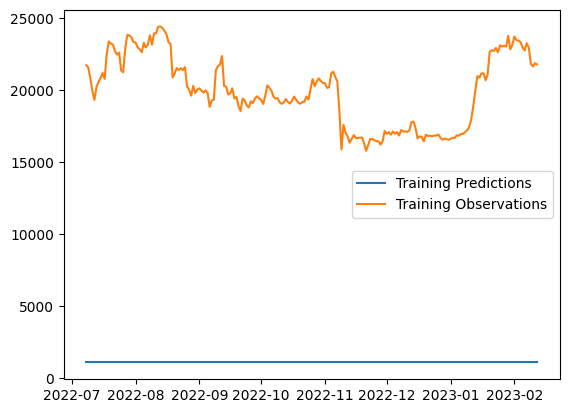

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 20ms/step


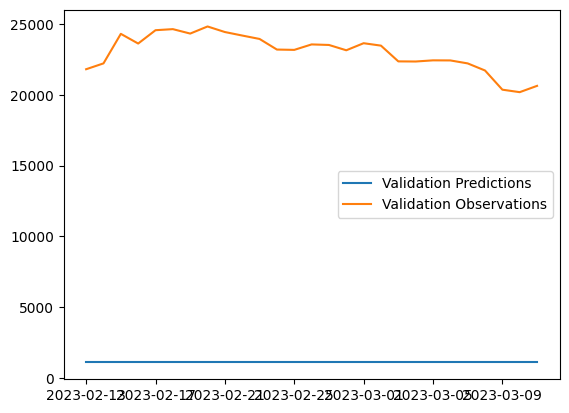

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 21ms/step


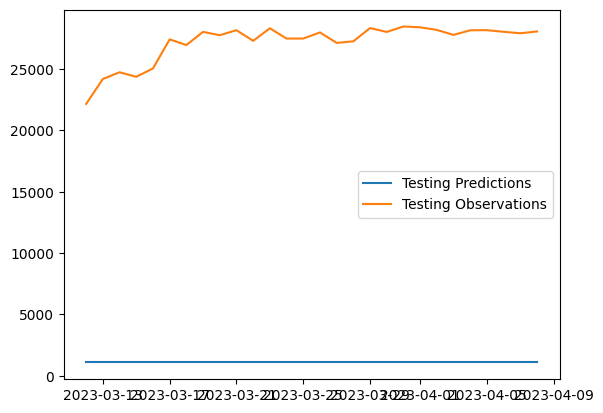

In [ ]:

test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

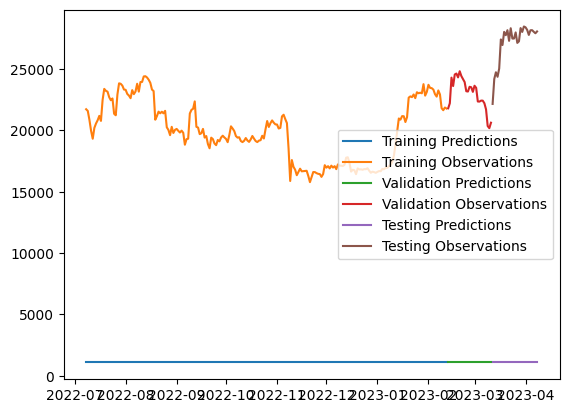

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])